---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.io as pio

pio.renderers.default = 'notebook'

In [52]:
df = pd.read_csv('../../data/processed-data/processed_df.csv', index_col=None)

In [53]:
target_column = 'Percent of Students Chronically Absent'
X = df.drop(columns=[target_column])
y = df[target_column]

In [54]:
#remove categorical and identifier variables
X = X.drop(['DBN','School Name','Borough','District','zip code'], axis=1)

In [55]:
#drop columns that cause perfect multicollinearity
X = X.drop(['Median Gross Rent','Median Household Income',"Percent Bachelor's Degree or Higher (25+)",'Percent No High School (25+)','Student Percent - Other', 'Percent Female','Percent who took ACT','Percent College Ready based on SAT Math'], axis=1)

In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

## Part 1: Dimensionality Reduction

### PCA 

Principal Component Analysis is an unsupervised learning technique used for dimensionality reduction. It uses linear transformations to find the most important features, or principal components. It is a great technique to use if you have many dimensions and need a way to visualize them in 2 dimensions. It is a good preprocessing technique to do before supervised learning. The goal is to capture as much of the variance contained in the features but in reduced dimensions. N_components specifies how many prinicipal components we want, here we are setting 2.

In [81]:
X_scaled.shape

(501, 45)

In [82]:
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X_scaled)

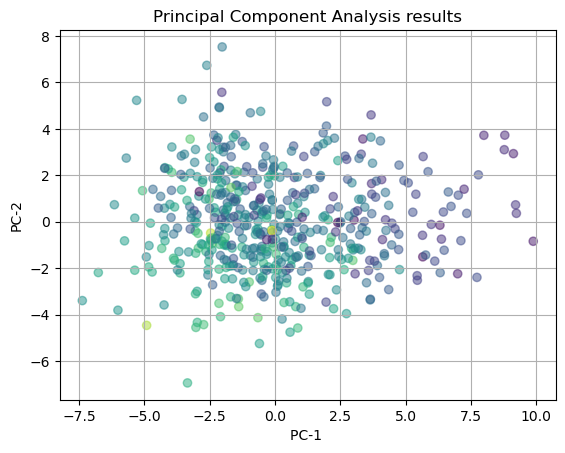

In [83]:
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0],X_pca[:,1],c=y, alpha=0.5) #, c=y
ax.set(xlabel='PC-1 ', ylabel='PC-2',
title='Principal Component Analysis results')
ax.grid()
plt.show()

In [84]:
def plot_variance_explained(pca):
    print("Variance explained by each principal component: ")
    print(pca.explained_variance_ratio_[0:10])
    print("Cumulative variance explained by each principal component: ")
    print(np.cumsum(pca.explained_variance_ratio_)[0:10])
    plt.plot(pca.explained_variance_ratio_, marker='o')
    plt.xlabel("number of components")
    plt.ylabel("explained variance ratio")
    plt.show()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("number of components")
    plt.ylabel("cumulative explained variance")
    plt.show()

Variance explained by each principal component: 
[0.19870456 0.09718321 0.07803125 0.05842354 0.04085942 0.037665
 0.03649138 0.03069061 0.03004234 0.02548714]
Cumulative variance explained by each principal component: 
[0.19870456 0.29588778 0.37391903 0.43234257 0.47320199 0.51086699
 0.54735837 0.57804899 0.60809133 0.63357846]


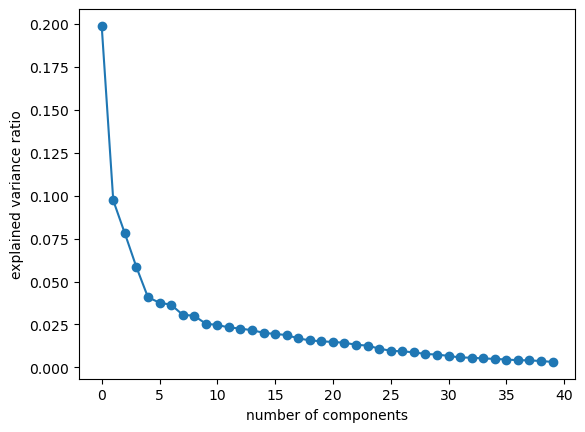

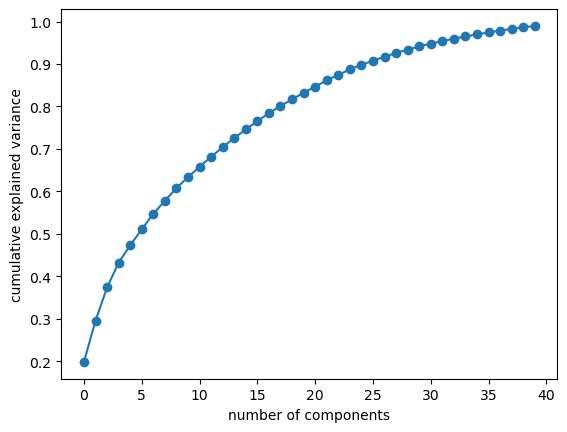

In [85]:
plot_variance_explained(pca)

### t-SNE

t-SNE is an unsupervised learning technique used to for dimensionality reduction. It is a better alternative for non-linear data. Perplexity is the most important hyperparameter in t_SNE. This paramter controls the balance between local and global structure. A high preplexity preseves global structure while a lower perplexity emphasizes local structure.

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

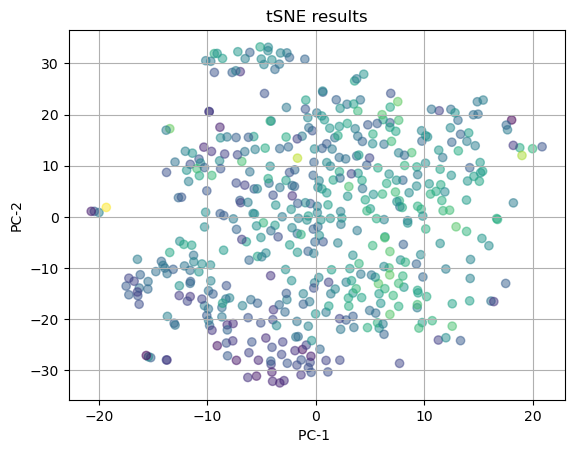

In [73]:
fig, ax = plt.subplots()
ax.scatter(X_tsne[:,0], X_tsne[:,1],c=y, alpha=0.5) #, c=y
ax.set(xlabel='PC-1 ', ylabel='PC-2',
title='tSNE results')
ax.grid()
plt.show()

### Kmeans Clustering

Kmeans is another unsupervised learning technique used for clustering. We use the elbow method to find the best number of clusters. We want to choose the number of clusters at the elbow of the graph becasue this indicates that the inertia reduction is decreasing, and there is diminishing returns in adding more clusters. The goal of clustering is to maximize the intercluster distance (distance between clusters - seapartion) and minimize intracluster distance (distance from points to center of cluster - cohesion). The goal is to minimize the variance within each cluster.


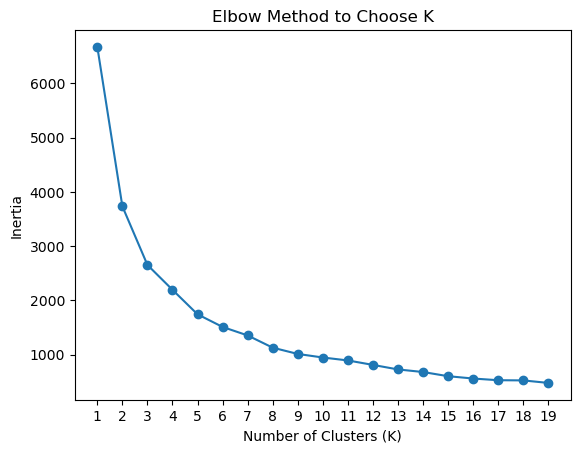

In [58]:
inertia = []
k_values = range(1, 20)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method to Choose K")
plt.xticks(k_values)
plt.show()

**Conclusion**: there is not large separation between the clusters, indicating that we may need to use an alternate dimensionality reduction technique